In [108]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, BayesianRidge, TweedieRegressor
from sklearn.svm import SVR
from sklearn.tree import ExtraTreeRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from pykrige.rk import RegressionKriging
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging
import gstools as gs

import warnings
warnings.simplefilter(action='ignore')

## Функции

In [109]:
"""
Удаление выбросов с использованием межквартильного размаха (IQR)
"""
def get_filter_df(df, col):
    # Определяем Q1 и Q3 квартили
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    
    # Вычисляем IQR
    IQR = Q3 - Q1
    
    # Определяем границы для определения выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Фильтруем выбросы
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

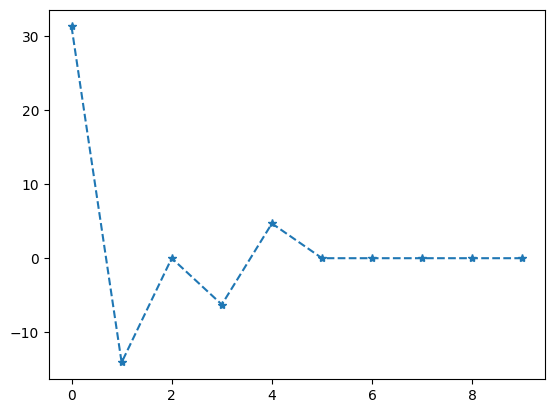

125.0 125.0


In [110]:
"""
Получение значений корреляции
"""
def get_corr(points, values, max_h, start=0, step=1):
    def matrix_distance_and_value(points, values):

        l = len(points)
        D = np.zeros((l, l))
        V = np.zeros((l, l))
        M = np.mean(values)

        for i in range(l):
            for j in range(i, l):
                distance = np.linalg.norm(points[i] - points[j])
                D[i, j] = distance
                V[i, j] = (values[i]-M)*(values[j]-M)
        return D, V
    
    
    corr_list, h_list = [], []
    D, V = matrix_distance_and_value(points, values)
    
    for h in range(start, max_h, step):
        corr_list.append(np.mean(np.where((D <= h) & (D > h-step), V, 0)))
        h_list.append(h)
    
    return np.array(h_list), np.array(corr_list)


# Пример построения корр функции
B = np.array([[1, 2, 3], [3, 4, 5], [1, 5, 7], [1, 2, 4]])
V = np.array([10, 20, 30, 40])
x, y = get_corr(B, V, 10)
plt.plot(x, y, "--*")
plt.show()
print(np.var(V), y[0]*4)

In [111]:
def my_R2(y_true, y_pred, y_mean):
    mse1 = mean_squared_error(y_true, y_pred)
    mse2 = mean_squared_error(y_true, [y_mean] * y_true.shape[0])
    return 1 - mse1/mse2

# example
y1 = np.array([1, 2, 3, 4, 5])
y2 = np.array([2, 2, 2, 4, 6])
print(r2_score(y1, y2), my_R2(y1, y2, np.mean(y1)))
print(r2_score(y1, [np.mean(y2)]*y1.shape[0]), my_R2(y1, [np.mean(y2)]*y1.shape[0], np.mean(y2)))

0.7 0.7
-0.020000000000000018 0.0


## Разбивка данных

In [112]:
"""
Чтение информации о скважинах
"""
df_boreholes = df_boreholes = pd.read_excel(f"data/координаты_скважин.xlsx")
house_3 = pd.read_excel("data/house_3_local.xlsx")

all_E = pd.DataFrame(columns=["borehole", "x", "y", "z", "h", "E"])

for borehole in house_3["тсз"]:
    """
    Запись данных по скважинам в один датафрейм
    """
    borehole_info = house_3[house_3["тсз"]==borehole]
    df_now = pd.read_excel(f"data/тсз{borehole}.xlsx")
    df_now = get_filter_df(df_now, "E").loc[:, ["h", "E"]]
    
    df_now["borehole"] = borehole 
    df_now["x"] = borehole_info["x"].iloc[0]
    df_now["y"] = borehole_info["y"].iloc[0]
    df_now["z"] = borehole_info["z"].iloc[0]

    all_E = pd.concat([all_E, df_now], ignore_index=True)

all_E["z_h"] = all_E["z"] - all_E["h"]
print(all_E.head(), all_E.shape)

"""
Деление без остатка абсолютной отметки на 1 и запись значение в 'group'
группировка и вычисление средних значений
"""
all_E["group"] = all_E["z_h"]//1
group_E = all_E.groupby(by=["group", "borehole"]).mean()
group_E["group"] = [int(x[0]) for x in group_E.index]
group_E["borehole"] = [int(x[1]) for x in group_E.index]

  borehole             x            y       z     h    E     z_h
0       51  97607.570697  4338.997129  76.631  0.00  0.0  76.631
1       51  97607.570697  4338.997129  76.631  0.05  6.0  76.581
2       51  97607.570697  4338.997129  76.631  0.10  6.0  76.531
3       51  97607.570697  4338.997129  76.631  0.15  6.0  76.481
4       51  97607.570697  4338.997129  76.631  0.20  6.0  76.431 (24429, 7)


In [113]:
"""
Разбивка данных на фиксированный шаг
"""
df_now = group_E.query('group == 65')

train = df_now.query('borehole >= 51 & borehole <=131')
test = df_now.query('borehole > 131')

p_train = train.loc[:, ["x", "y"]].to_numpy()
p_test = test.loc[:, ["x", "y"]].to_numpy()
x_train = train.loc[:, ["x", "y"]].to_numpy()
x_test = test.loc[:, ["x", "y"]].to_numpy()
target_train = train.loc[:, ["E"]].to_numpy().reshape(-1)
target_test = test.loc[:, ["E"]].to_numpy().reshape(-1)

In [114]:
"""
Случайная разбивка данных
"""
df_now = group_E.query('group == 65')

p = df_now.loc[:, ["x", "y"]].to_numpy() # Выборка для модели регрессии
x = df_now.loc[:, ["x", "y"]].to_numpy() # Выборка для кригинга
target = df_now["E"].to_numpy() # Известные значения

p_train, p_test, x_train, x_test, target_train, target_test = train_test_split(
    p, x, target, test_size=0.3, random_state=123
)

In [133]:
"""
Разбивка определенных скважин
"""
df_now = group_E.query('group == 65')
boreholes_train = np.unique(list(range(51, 160, 6)) + [51, 59, 91, 123, 131]) #list(range(51, 131, 6))#[51, 61, 71, 81, 91, 101, 111, 121, 131, 123, 115, 107, 99, 83, 75, 67, 136]
data_train = df_now.query('borehole in @boreholes_train')
data_test = df_now.query('borehole not in @boreholes_train')

p_train = data_train.loc[:, ["x", "y"]].to_numpy()
p_test = data_test.loc[:, ["x", "y"]].to_numpy()
x_train = data_train.loc[:, ["x", "y"]].to_numpy()
x_test = data_test.loc[:, ["x", "y"]].to_numpy()
target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)

In [134]:
data_train.shape

(20, 8)

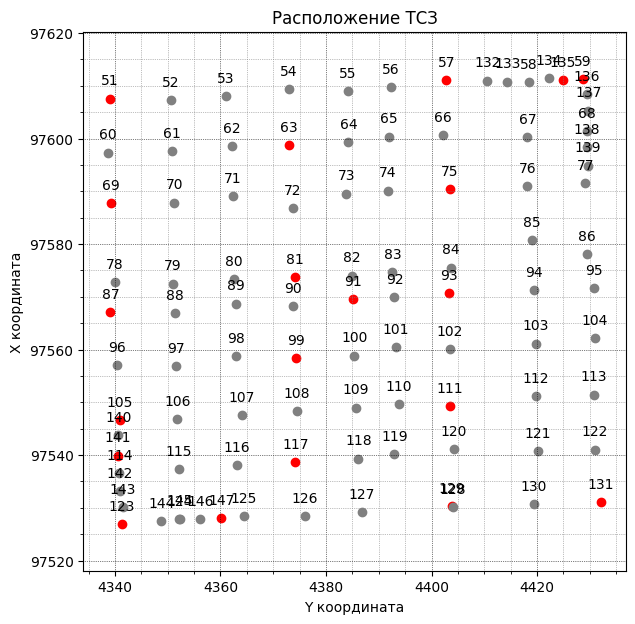

In [135]:
plt.figure(figsize=(7, 7))

y = house_3.query('тсз in @boreholes_train')["x"].reset_index(drop=True)
x = house_3.query('тсз in @boreholes_train')["y"].reset_index(drop=True)
labels = house_3.query('тсз in @boreholes_train')["тсз"].reset_index(drop=True)
for i in range(len(x)):
    plt.scatter(x[i], y[i], label=f'{labels[i]} ({x[i]}, {y[i]})', color="red")
    plt.annotate(labels[i], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
y = house_3.query('тсз not in @boreholes_train')["x"].reset_index(drop=True)
x = house_3.query('тсз not in @boreholes_train')["y"].reset_index(drop=True)
labels = house_3.query('тсз not in @boreholes_train')["тсз"].reset_index(drop=True)
for i in range(len(x)):
    plt.scatter(x[i], y[i], label=f'{labels[i]} ({x[i]}, {y[i]})', color="gray")
    plt.annotate(labels[i], (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Расположение ТСЗ')
plt.xlabel('Y координата')
plt.ylabel('X координата')
plt.axis('equal')
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.show()

## Универсальный кригинг

In [136]:
r2_dict = {}

0.467375370453739


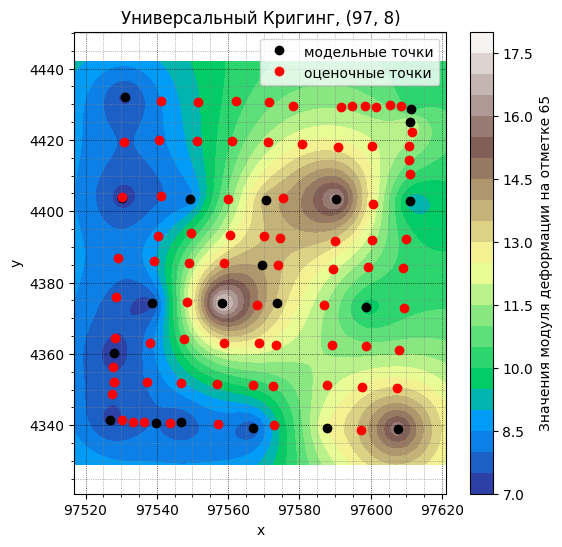

In [137]:
model = 'exponential'

x = x_train[:, 0]
y = x_train[:, 1]
E = target_train

OK = UniversalKriging(x_train[:, 0], 
                      x_train[:, 1], 
                      target_train, 
                      variogram_model=model,
                      variogram_parameters={'sill':28, 'range': 50, 'nugget': 1}
                     )

predict_test, var_test = OK.execute('points', x_test[:, 0], x_test[:, 1])
print(my_R2(target_test, predict_test, np.mean(target_train)))
r2_dict["UK"] = [r2_score(target_test, predict_test), my_R2(target_test, predict_test, np.mean(target_train))]


x_new = np.linspace(np.min(x_train[:, 0])-10, np.max(x_train[:, 0])+10, 200)
y_new = np.linspace(np.min(x_train[:, 1])-10, np.max(x_train[:, 1])+10, 200)
    
z_new, variance = OK.execute('grid', x_new, y_new)
    
X, Y = np.meshgrid(x_new, y_new)
    
    
plt.figure(figsize=(6, 6))
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
plt.axis('equal')
    
plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
cbar = plt.colorbar()
cbar.set_label(f'Значения модуля деформации на отметке 65')

plt.plot(x, y, "ok", label="модельные точки")
plt.plot(x_test[:, 0], x_test[:, 1], "o", color="red", label="оценочные точки")
plt.legend()    
plt.title(f'Универсальный Кригинг, {df_now.shape}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Регрессия+кригинг

In [120]:
svr_model1 = SVR(C=0.1, gamma="auto", kernel='rbf')
svr_model2 = SVR(C=0.1, gamma="auto", kernel="sigmoid")
svr_model3 = SVR(C= 10, coef0= np.min(target_test), epsilon= 0.1, 
                 gamma= 'scale', kernel= 'sigmoid'
                )
lr_model = LinearRegression(copy_X=True, fit_intercept=False)
br_model = BayesianRidge()
et_model = ExtraTreeRegressor()
tr_model = TweedieRegressor()

In [121]:
reg_models = [svr_model2, svr_model3, lr_model, br_model, et_model, tr_model]
name_models = ["SVR1", "SVR2", "LR", "BR", "ET", "TR"]
dict_models = {}

model_kind = 'exponential'

for i in range(len(reg_models)):
    m =reg_models[i]
    name = name_models[i]
    
    print("=" * 40)
    print("regression model:", m.__class__.__name__, name_models[i])
    
    try:
        m_rk = RegressionKriging(regression_model=m, n_closest_points=10, variogram_model=model)
        m_rk.fit(p_train, x_train, target_train)
        predict_test = m_rk.predict(p_test, x_test)
        dict_models[name] = m_rk
        r2_dict[name] = [r2_score(target_test, predict_test), my_R2(target_test, predict_test, np.mean(target_train))]
        print(r2_score(target_test, predict_test), my_R2(target_test, predict, np.mean(target_train)))
        print("Regression Score: ", m_rk.regression_model.score(p_test, target_test))
        print("RK score: ", m_rk.score(p_test, x_test, target_test))
    except Exception as ex:
        print(ex)

regression model: SVR SVR1
Finished learning regression model
Finished kriging residuals
name 'predict' is not defined
regression model: SVR SVR2
Finished learning regression model
Finished kriging residuals
name 'predict' is not defined
regression model: LinearRegression LR
Finished learning regression model
Finished kriging residuals
name 'predict' is not defined
regression model: BayesianRidge BR
Finished learning regression model
Finished kriging residuals
name 'predict' is not defined
regression model: ExtraTreeRegressor ET
Finished learning regression model
Each lower bound must be strictly less than each upper bound.
regression model: TweedieRegressor TR
Finished learning regression model
Finished kriging residuals
name 'predict' is not defined


In [122]:
r2_dict["mean_train"] = [r2_score(target_test, predict_test), my_R2(target_test, [np.mean(target_train)]*target_test.shape[0], np.mean(target_train))]
r2_dict["count"] = [target_test.shape[0], target_train.shape[0]]
df_result = pd.DataFrame(r2_dict, index=["R2", "R2_train"]).applymap(lambda x: round(x, 3))

In [123]:
df_result.loc[:, ["UK", "count"]]

,UK,count
R2,0.396,75
R2_train,0.398,22


In [124]:
list_boreholes_train = [[]] + \
                       [list(range(51, 160, i)) for i in range(2, 12)] + \
                       [list(range(51, 131, i)) for i in range(2, 12)]

In [125]:
for i in range(len(list_boreholes_train)):
    list_boreholes_train[i] = np.unique(list_boreholes_train[i] + [51, 59, 91, 123, 131])

In [126]:
model = 'exponential'
df_now = group_E.query('group == 65')

result_r2_count = {}

for boreholes_train in list_boreholes_train:
    """
    Разбивка определенных скважин
    """
    data_train = df_now.query('borehole in @boreholes_train')
    data_test = df_now.query('borehole not in @boreholes_train')

    p_train = data_train.loc[:, ["x", "y"]].to_numpy()
    p_test = data_test.loc[:, ["x", "y"]].to_numpy()
    x_train = data_train.loc[:, ["x", "y"]].to_numpy()
    x_test = data_test.loc[:, ["x", "y"]].to_numpy()
    target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
    target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)
    """
    Кригинг
    """
    x = x_train[:, 0]
    y = x_train[:, 1]
    E = target_train

    OK = UniversalKriging(x_train[:, 0], 
                          x_train[:, 1], 
                          target_train, 
                          variogram_model=model,
                          variogram_parameters={'sill':28, 'range': 50, 'nugget': 1}
                         )

    predict_test, var_test = OK.execute('points', x_test[:, 0], x_test[:, 1])
    print(target_train.shape, my_R2(target_test, predict_test, np.mean(target_train)))
    result_r2_count[len(boreholes_train)] = [r2_score(target_test, predict_test), my_R2(target_test, predict_test, np.mean(target_train))]

    x_new = np.linspace(np.min(x_train[:, 0])-10, np.max(x_train[:, 0])+10, 200)
    y_new = np.linspace(np.min(x_train[:, 1])-10, np.max(x_train[:, 1])+10, 200)

    z_new, variance = OK.execute('grid', x_new, y_new)

    X, Y = np.meshgrid(x_new, y_new)
    
    
# plt.figure(figsize=(6, 6))
# plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
# plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
# plt.minorticks_on()
# plt.axis('equal')
    
# plt.contourf(X, Y, z_new, cmap='terrain', levels=20)
# cbar = plt.colorbar()
# cbar.set_label(f'Значения модуля деформации на отметке 65')

# plt.plot(x, y, "ok", label="модельные точки")
# plt.plot(x_test[:, 0], x_test[:, 1], "o", color="red", label="оценочные точки")
# plt.legend()    
# plt.title(f'Универсальный Кригинг, {df_now.shape}')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

(5,) 0.22371136996385732
(49,) 0.7071961042511841
(36,) 0.4913557573641083
(25,) 0.5643980780695834
(22,) 0.39752145439547026
(20,) 0.467375370453739
(18,) 0.3434399204220707
(13,) 0.08555587866503278
(14,) 0.25024582309844334
(12,) 0.3094122143291821
(13,) 0.39848156631640363
(41,) 0.637308258259554
(30,) 0.5011025711486536
(21,) 0.537578090235994
(19,) 0.38312739589488276
(17,) 0.4899225211280963
(16,) 0.3412795282134682
(11,) 0.20053357850533748
(12,) 0.24598523374290882
(11,) 0.31217684364280707
(12,) 0.42661770663301324


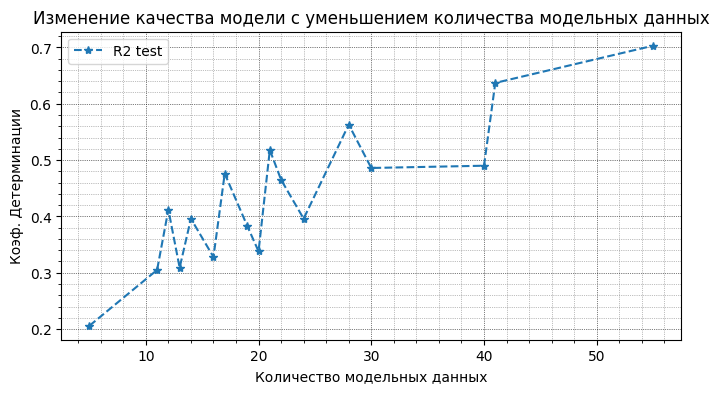

In [127]:
df_r2_count = pd.DataFrame(result_r2_count, index=["R2", "R2_train"]).applymap(lambda x: round(x, 3)).T
df_r2_count["count"] = df_r2_count.index
df_r2_count = df_r2_count.sort_values(by="count")
df_r2_count = df_r2_count.query("R2 > 0 & R2_train > 0")

plt.figure(figsize=(8, 4))
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
    
plt.plot(df_r2_count["count"], df_r2_count["R2"], "--*", label="R2 test")
#plt.plot(df_r2_count["count"], df_r2_count["R2_train"], "--o", label="R2 train")
plt.legend()    
plt.title(f'Изменение качества модели с уменьшением количества модельных данных')
plt.xlabel('Количество модельных данных')
plt.ylabel('Коэф. Детерминации')
plt.show()

df_r2_uk = df_r2_count.copy()

(5,) -0.07074386187692272
(49,) 0.08298910963627792
(36,) 0.11572535610117063
(25,) 0.12352250774231444
(22,) 0.05307871521344765
(20,) 0.013607965614363504
(18,) 0.09227319691687907
(13,) -0.2723749382896852
(14,) -0.049609728593254854
(12,) 0.003125754810910375
(13,) 0.02052493549868728
(41,) 0.12352583581013021
(30,) 0.12535811202108138
(21,) 0.1380050506395908
(19,) 0.05379470273996523
(17,) 0.05455624293479178
(16,) 0.06729099149067119
(11,) -0.06718267590239413
(12,) -0.015128355450185094
(11,) -0.00122374337525466
(12,) 0.03349704996363634


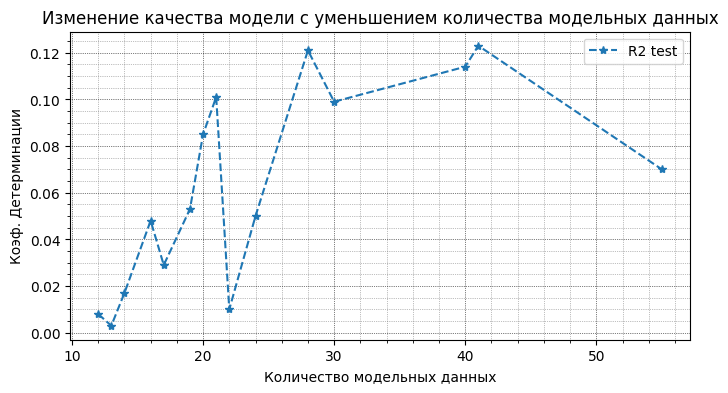

In [128]:
"""
Линейная модель
"""
# list_boreholes_train = [list(range(51, 160, i)) for i in range(2, 12)
#                        ] + \
#                         [list(range(51, 131, i)) for i in range(2, 12)
#                        ]

model = TweedieRegressor()
#model = SVR(C=0.1, gamma="auto", kernel='rbf')
df_now = group_E.query('group == 65')

result_r2_count = {}

for boreholes_train in list_boreholes_train:
    """
    Разбивка определенных скважин
    """
    data_train = df_now.query('borehole in @boreholes_train')
    data_test = df_now.query('borehole not in @boreholes_train')

    p_train = data_train.loc[:, ["x", "y"]].to_numpy()
    p_test = data_test.loc[:, ["x", "y"]].to_numpy()
    x_train = data_train.loc[:, ["x", "y"]].to_numpy()
    x_test = data_test.loc[:, ["x", "y"]].to_numpy()
    target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
    target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)
    """
    ML
    """
    model.fit(p_train, target_train)
    predict_test = model.predict(p_test)
    print(target_train.shape, my_R2(target_test, predict_test, np.mean(target_train)))
    result_r2_count[len(boreholes_train)] = [r2_score(target_test, predict_test), 
                                             my_R2(target_test, predict_test, np.mean(target_train))
                                            ]

df_r2_count = pd.DataFrame(result_r2_count, index=["R2", "R2_train"]).applymap(lambda x: round(x, 3)).T
df_r2_count["count"] = df_r2_count.index
df_r2_count = df_r2_count.sort_values(by="count")
df_r2_count = df_r2_count.query("R2 > 0 & R2_train > 0")

plt.figure(figsize=(8, 4))
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
    
plt.plot(df_r2_count["count"], df_r2_count["R2"], "--*", label="R2 test")
#plt.plot(df_r2_count["count"], df_r2_count["R2_train"], "--o", label="R2 train")
plt.legend()    
plt.title(f'Изменение качества модели с уменьшением количества модельных данных')
plt.xlabel('Количество модельных данных')
plt.ylabel('Коэф. Детерминации')
plt.show()

df_r2_lr = df_r2_count.copy()

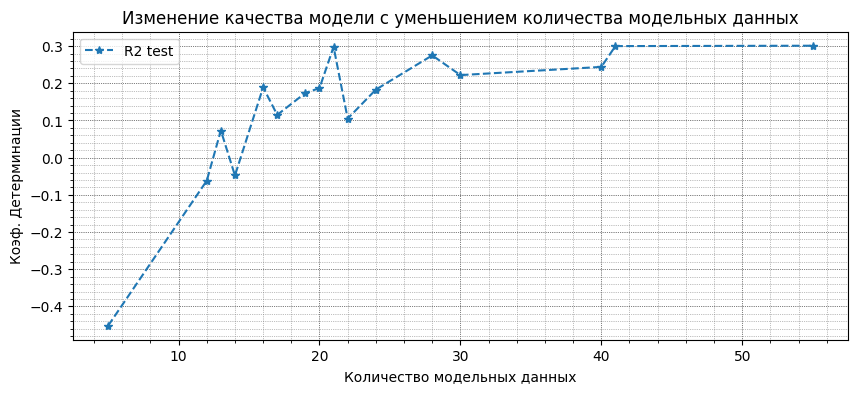

In [129]:
"""
Полином 2 степени
"""
# list_boreholes_train = [list(range(51, 160, i)) for i in range(2, 12)
#                        ] + \
#                         [list(range(51, 131, i)) for i in range(2, 12)
#                        ]

poly_features = PolynomialFeatures(degree=2, include_bias=False)
model = LinearRegression()

df_now = group_E.query('group == 65')

result_r2_count = {}

for boreholes_train in list_boreholes_train:
    """
    Разбивка определенных скважин
    """
    data_train = df_now.query('borehole in @boreholes_train')
    data_test = df_now.query('borehole not in @boreholes_train')

    p_train = data_train.loc[:, ["x", "y"]].to_numpy()
    p_test = data_test.loc[:, ["x", "y"]].to_numpy()
    x_train = data_train.loc[:, ["x", "y"]].to_numpy()
    x_test = data_test.loc[:, ["x", "y"]].to_numpy()
    target_train = data_train.loc[:, ["E"]].to_numpy().reshape(-1)
    target_test = data_test.loc[:, ["E"]].to_numpy().reshape(-1)
    """
    poly
    """
    X_poly = poly_features.fit_transform(np.c_[x_train[:, 0], x_train[:, 1]])

    model.fit(X_poly, target_train)

    coeffs = model.coef_
    test_X_poly = poly_features.transform(np.c_[x_test[:, 0], x_test[:, 1]])
    predict_test = model.predict(test_X_poly)
    result_r2_count[len(boreholes_train)] = [r2_score(target_test, predict_test), 
                                             my_R2(target_test, predict_test, np.mean(target_train))
                                            ]

df_r2_count = pd.DataFrame(result_r2_count, index=["R2", "R2_train"]).applymap(lambda x: round(x, 3)).T
df_r2_count["count"] = df_r2_count.index
df_r2_count = df_r2_count.sort_values(by="count")
df_r2_count = df_r2_count.query("R2 > -1 & R2_train > -1")

plt.figure(figsize=(10, 4))
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
    
plt.plot(df_r2_count["count"], df_r2_count["R2"], "--*", label="R2 test")
#plt.plot(df_r2_count["count"], df_r2_count["R2_train"], "--o", label="R2 train")
plt.legend()    
plt.title(f'Изменение качества модели с уменьшением количества модельных данных')
plt.xlabel('Количество модельных данных')
plt.ylabel('Коэф. Детерминации')
plt.show()

df_r2_poly = df_r2_count.copy()


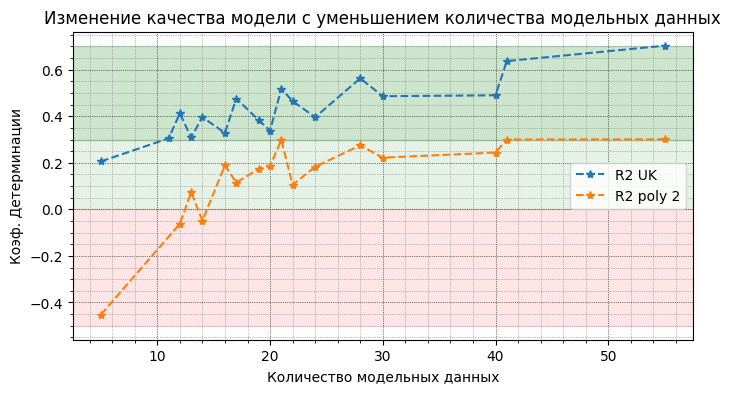

In [147]:
plt.figure(figsize=(8, 4))
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()
    
plt.plot(df_r2_uk["count"], df_r2_uk["R2"], "--*", label="R2 UK")
#plt.plot(df_r2_lr["count"], df_r2_lr["R2"], "--*", label="R2 linear")
plt.plot(df_r2_poly["count"], df_r2_poly["R2"], "--*", label="R2 poly 2")
#plt.plot([5, 56], [0, 0], label="R2=0")
plt.axhspan(0, -0.5, color='red', alpha=0.1)
plt.axhspan(0.3, 0, color='green', alpha=0.1)
plt.axhspan(0.7, 0.3, color='green', alpha=0.2)
plt.legend()    
plt.title(f'Изменение качества модели с уменьшением количества модельных данных')
plt.xlabel('Количество модельных данных')
plt.ylabel('Коэф. Детерминации')
plt.show()

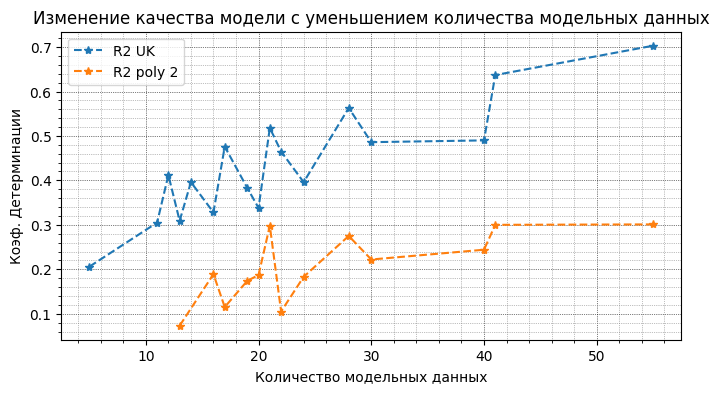

In [138]:
plt.figure(figsize=(8, 4))
plt.grid(which='major', linestyle=':', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.minorticks_on()

df_now_1 = df_r2_uk.query("R2 >= 0")
df_now_2 = df_r2_poly.query("R2 >= 0")

plt.plot(df_now_1["count"], df_now_1["R2"], "--*", label="R2 UK")
#plt.plot(df_r2_lr["count"], df_r2_lr["R2"], "--*", label="R2 linear")
plt.plot(df_now_2["count"], df_now_2["R2"], "--*", label="R2 poly 2")
plt.legend()    
plt.title(f'Изменение качества модели с уменьшением количества модельных данных')
plt.xlabel('Количество модельных данных')
plt.ylabel('Коэф. Детерминации')
plt.show()

In [131]:
svr_model1 = SVR(C=0.1, gamma="auto", kernel='rbf')
svr_model2 = SVR(C=0.1, gamma="auto", kernel="sigmoid")
svr_model3 = SVR(C= 10, coef0= np.min(target_test), epsilon= 0.1, 
                 gamma= 'scale', kernel= 'sigmoid'
                )
lr_model = LinearRegression(copy_X=True, fit_intercept=False)
br_model = BayesianRidge()
et_model = ExtraTreeRegressor()
tr_model = TweedieRegressor()

In [132]:
models = [svr_model1, svr_model2, lr_model, br_model, et_model, tr_model]
name_models = ["SVR1", "SVR2", "LR", "BR", "ET", "TR"]
dict_models = {}

for i in range(len(models)):
    m = models[i]
    name = name_models[i]
    
    print("=" * 40)
    print("regression model:", m.__class__.__name__, name_models[i])

    m.fit(p_train, target_train)


    predict_test = m.predict(p_test)
    
    r2_now = r2_score(target_test, predict_test)
    mae_now = mean_absolute_error(target_test, predict_test)
    rmse_now = mean_squared_error(target_test, predict_test)**0.5
    print(r2_now, mae_now, rmse_now)
    r2_dict[name] = [r2_now, mae_now, rmse_now]


regression model: SVR SVR1
0.0003939363700719012 2.5030127528784454 3.102823448468712
regression model: SVR SVR2
-0.0003589970385831087 2.5041285942653633 3.1039917985610046
regression model: LinearRegression LR
-0.11029398429919368 2.75096878158577 3.2701043943680403
regression model: BayesianRidge BR
0.05988363391388041 2.5573734378468322 3.0090778959255204
regression model: ExtraTreeRegressor ET
-0.09823871712458332 2.4512937129444143 3.2523029940669987
regression model: TweedieRegressor TR
0.008293510814521898 2.6012407910398196 3.0905388077119667
